In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.colors import Normalize
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import Image
import pickle

In [4]:
with open(r"HighRankedMovies_ByCountry.pickle", "rb") as input_file:
    movies = pickle.load(input_file)

In [15]:
movies['Aruba']['movies']

[{'adult': False,
  'backdrop_path': '/dwxdn3ppDAn7QtaLlhGDEErWfg9.jpg',
  'genre_ids': [18],
  'id': 5708,
  'original_language': 'en',
  'original_title': 'Control',
  'overview': "The story of Joy Division’s lead singer Ian Curtis, from his schoolboy days in 1973 to his suicide on the eve of the band's first American tour in 1980.",
  'popularity': 14.607,
  'poster_path': '/jOJiaOhwrDdwqTRZvZOhbndqHGp.jpg',
  'release_date': '2007-09-12',
  'title': 'Control',
  'video': False,
  'vote_average': 7.529,
  'vote_count': 769,
  'country': ['United States of America', 'Aruba']},
 {'adult': False,
  'backdrop_path': '/cQrq7h8Giz6pDg1jH6kCAjLqI7m.jpg',
  'genre_ids': [28, 80, 53],
  'id': 37498,
  'original_language': 'en',
  'original_title': 'Knock Off',
  'overview': 'Marcus Ray, a sales representative for "V SIX" jeans, and his partner, Tommy Hendricks, are about to be busted for selling "knock off" jeans. Their American contact, Karan Leigh, who by the way is not only their employer

In [33]:
def select_entry(data):

    Selected_Films = {}

    for country in data:
        max_popularity_entry = max(data[country]['movies'], key= lambda x: x['vote_average'])
        # Filter out entries where the country in question is not the primary film.
        if max_popularity_entry['country'] == country:
            selected_entry = max_popularity_entry
        else:
            filtered_data = [entry for entry in data[country]['movies'] if entry['country'] == country]
            if filtered_data:
                selected_entry = max(filtered_data, key=lambda x: x['vote_average'])
            else:
                selected_entry = max_popularity_entry
        print(select_entry)
        Selected_Films[country] = select_entry
    return Selected_Films

select_entry(movies)

<function __main__.select_entry(data)>

Fiji


C:\Users\Luke\AppData\Local\Temp\ipykernel_1728\2210667121.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


FileNotFoundError: [Errno 2] No such file or directory: 'path/to/images/fiji.jpg'

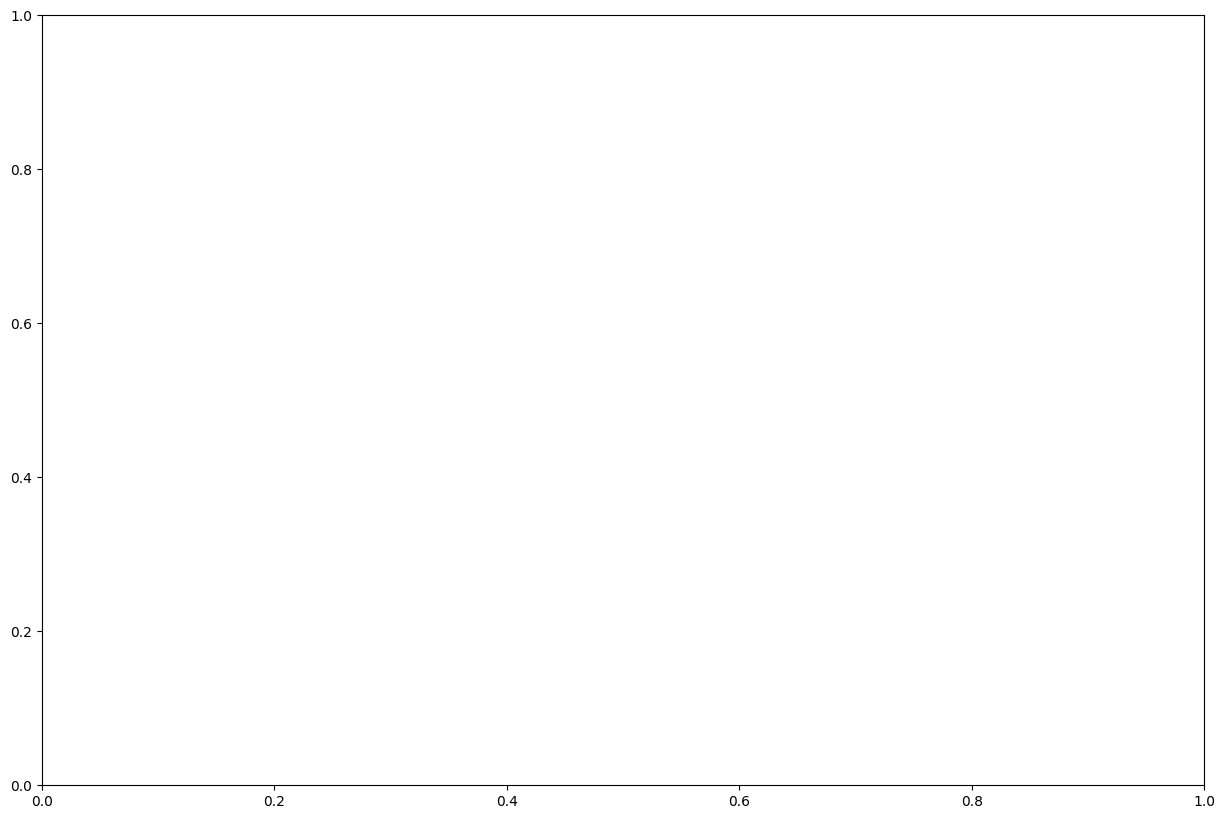

In [7]:
# Load the world map data
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Function to create an image annotation for a country
def create_image_annotation(ax, image_path, extent, zoom=1):
    img = Image.open(image_path)
    img = img.resize((int(img.width * zoom), int(img.height * zoom)))

    imagebox = OffsetImage(img, zoom=zoom)
    ab = AnnotationBbox(imagebox, extent, frameon=False, pad=0)
    ax.add_artist(ab)

# Create a plot
fig, ax = plt.subplots(figsize=(15, 10))

# Loop through each country and plot it
for idx, row in world.iterrows():
    country_name = row['name']
    print(country_name)
    geometry = row['geometry']
    boundary = geometry.boundary

    # Example: Use a sample JPEG image for each country
    image_path = f'path/to/images/{country_name.lower()}.jpg'

    if country_name.lower() == 'united states':
        image_path = 'path/to/images/usa.jpg'

    create_image_annotation(ax, image_path, boundary, zoom=0.2)

# Set plot limits
ax.set_xlim([-180, 180])
ax.set_ylim([-60, 90])

# Hide the axes
ax.axis('off')

# Show the plot
plt.show()